In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from util import *
from extract_direct_indicators import *
from extract_indirect_indicators import *
from extract_time_indicator import *
from extract_linestrings import *

### For Sidewalk Geometries

### Direct Indicator

In [80]:
dir_ind = extract_direct_indicators(sidewalk_qualifer, 'sea')
dir_ind = dir_ind[dir_ind['visibility'] == 'V'] # Exclude deleted or changed entries
stats = get_stats_dir(dir_ind)
# Using ceil(mean) as central tendency measure
stats = stats.loc['mean'].apply(np.ceil).to_dict()

In [81]:
def compute_dir(**kwargs):
    res = dict()
    for key in kwargs:
        res[key]  = 1 if kwargs[key] >= stats[key] else 0

    Wnum, Wdir_c, Wuc, Wedit, WrollB, WTag = 0.2, 0.2, 0.2, 0.1, 0.1, 0.2
    Td = (Wnum * res['nversions']) + (Wdir_c * res['dir_confirmations']) + \
         (Wuc * res['nusers']) + (Wedit * res['nedits']) + \
         (WrollB * res['nrollbacks']) + (WTag * res['ntags'])

    return Td

dir_ind['Td'] = dir_ind.apply(lambda row: compute_dir(
                                                    nversions = row.nversions, 
                                                    dir_confirmations = row.dir_confirmations, 
                                                    nusers = row.nusers, 
                                                    nedits = row.nedits, 
                                                    nrollbacks = row.nrollbacks, 
                                                    ntags = row.ntags
                                                    ), 
                                                    axis=1)

### Time Indicator

In [82]:
time_ind = extract_time_indicator(sidewalk_qualifer, 'sea')
stats = get_stats(time_ind)
avg = stats.loc['mean'].apply(np.ceil)[0] # Average last edit
time_ind['Ttime'] = time_ind.apply(lambda row: 1 if row['last_edit(months)'] >= avg else 0, axis=1)

### Indirect Indicator

In [83]:
indir_ind = extract_indirect_indicators('sea')

stats = get_stats_indir(indir_ind)
# Using ceil(mean) as central tendency measure
stats = stats.loc['mean'].apply(np.ceil).to_dict()

invalid area (area_id=210393692)
osmium.osm.Area(id=210393692, deleted=False, visible=True, version=11, changeset=0, uid=0, timestamp=datetime.datetime(2021, 9, 1, 2, 58, 4, tzinfo=datetime.timezone.utc), user='', tags=osmium.osm.TagList({'landuse': 'residential', 'name': 'Olympic Manor'}))


In [84]:
def compute_indir(**kwargs):
    cnt = 0
    for key in kwargs:
        cnt  += 1 if kwargs[key] >= stats[key] else 0

    Ti = 1 if cnt >= 6 else 0

    return Ti

indir_ind['Ti'] = indir_ind.apply(lambda row: compute_indir(
                                                    road_cnt = row.road_cnt, 
                                                    road_uc = row.road_uc, 
                                                    road_le_time = row.road_le_time, 
                                                    building_cnt = row.building_cnt, 
                                                    building_uc = row.building_uc, 
                                                    building_le_time = row.building_le_time,
                                                    poi_cnt = row.poi_cnt,
                                                    poi_uc = row.poi_uc,
                                                    poi_le_time = row.poi_le_time,
                                                    sidewalk_cnt = row.sidewalk_cnt,
                                                    sidewalk_uc = row.sidewalk_uc,
                                                    sidewalk_le_time = row.sidewalk_le_time
                                                    ), 
                                                    axis=1)

In [85]:
def compute_trust(Td, Ti, Ttime):
    trust = Td * 0.5 + Ti * 0.25 + Ttime * 0.25
    return trust

# Td(F).Wd + Ti(F).Wi + Ttime(F).Wtime
result = pd.merge(dir_ind, indir_ind, on="id")[['id', 'Td', 'Ti']]
result = pd.merge(result, time_ind, on="id")[['id', 'Td', 'Ti', 'Ttime']]
result['Trust'] = result.apply(lambda row: compute_trust(
                                                        row.Td,
                                                        row.Ti,
                                                        row.Ttime
                                                        ),
                                                        axis = 1)

In [86]:
h = WayHandler()
h.apply_file("data/osm/latest/sea.osm.pbf", locations = True)
sidewalk = h.get_gdf(sidewalk_qualifer)

highway = h.get_gdf(highway_qualifier)

In [87]:
result = pd.merge(result, sidewalk, on="id")[['id', 'Td', 'Ti', 'Trust', 'tags', 'geometry']]
result = gpd.GeoDataFrame(result, crs="EPSG:4326")
result.to_csv('data/trust_indicator_seattle.csv', index=False)

C:\Users\qshah\AppData\Local\Temp\ipykernel_5036\2769422711.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


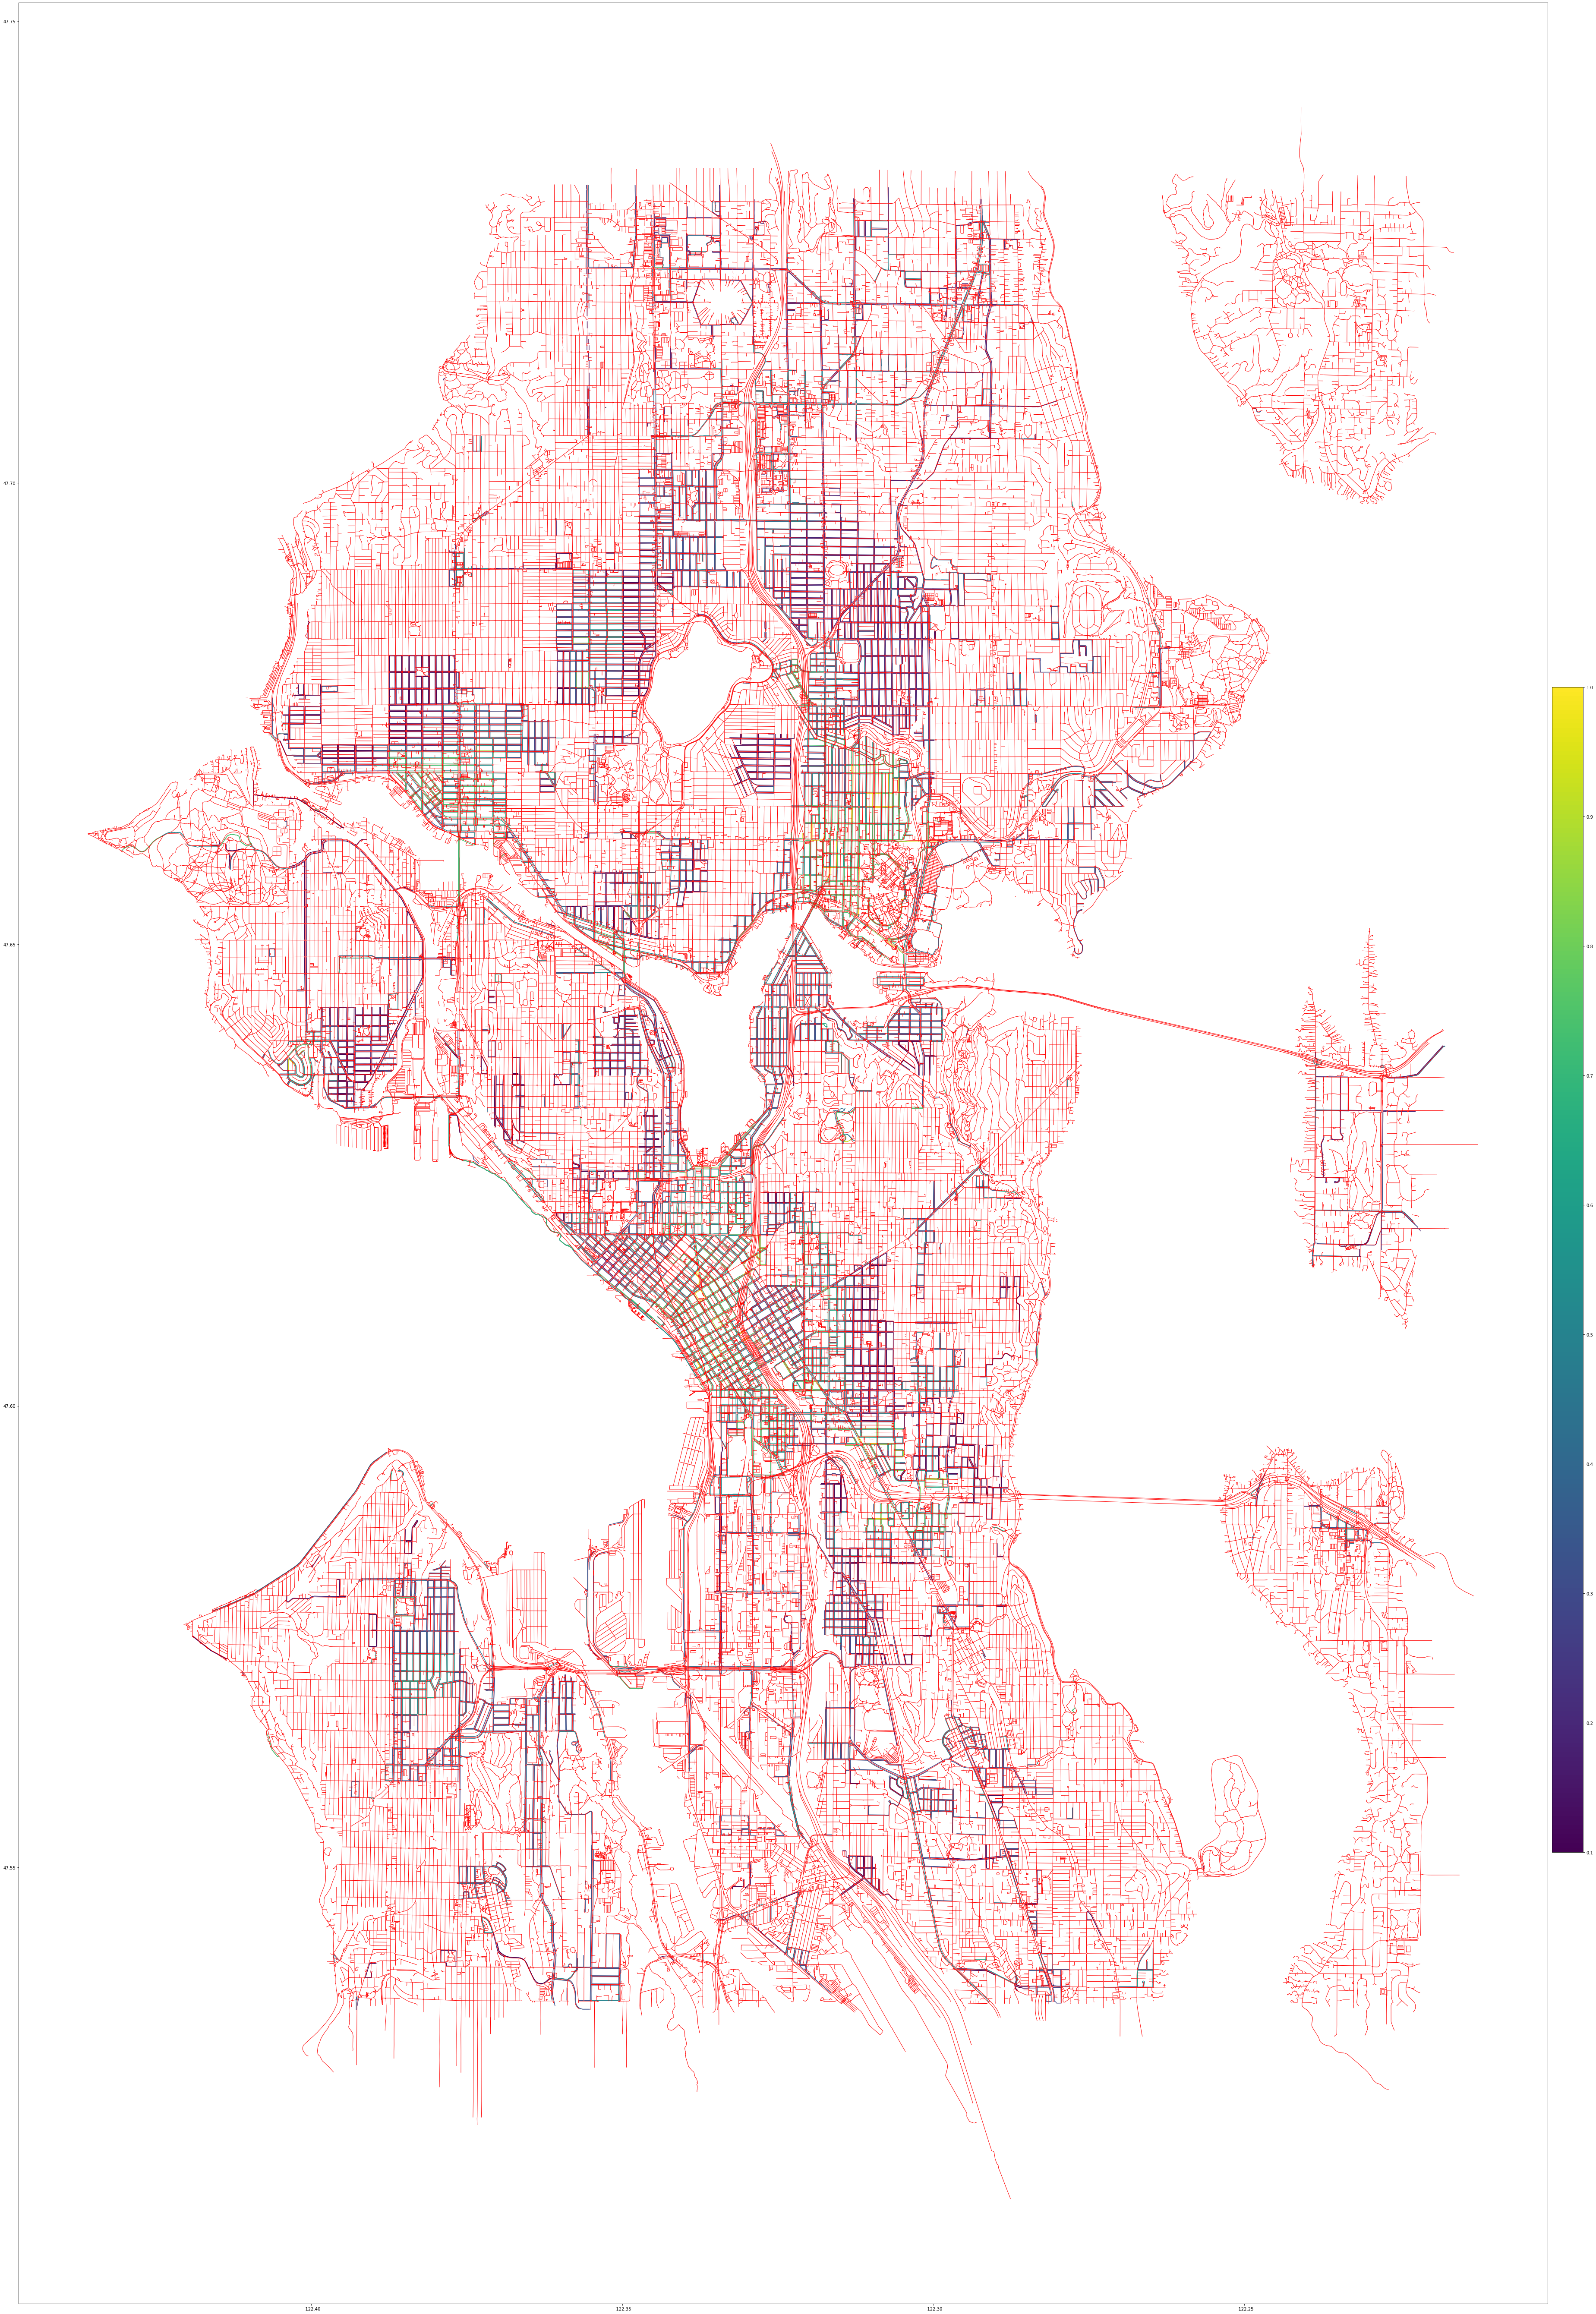

In [88]:
fig, ax = plt.subplots(figsize=(50,150))

highway.plot(color = 'red', lw = 1, ax=ax)
result.plot(column = 'Trust', lw=1.5, ax=ax, cmap='viridis', legend = False)
# plt.legend(title="My Title", fontsize=5)
# plt.legend(prop = { 'size' : 30 })
# plt.savefig('data/sea_sidewalk.png', dpi=400)

fig = ax.get_figure()
cax = fig.add_axes([1, 0.35, 0.02, 0.25]) # 3rd -> width
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0.1, vmax=1))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
# cbr.ax.tick_params(labelsize=200) 
plt.tight_layout()
plt.savefig('data/sea_sidewalk_trust.png', dpi=400)
plt.show()

In [1]:
trust_sea = pd.read_csv('data/trust_indicator_seattle.csv')
trust_sea = trust_sea.drop('Unnamed: 0', axis = 1)

In [8]:
# figure size in inches
rcParams['figure.figsize'] = 5,10

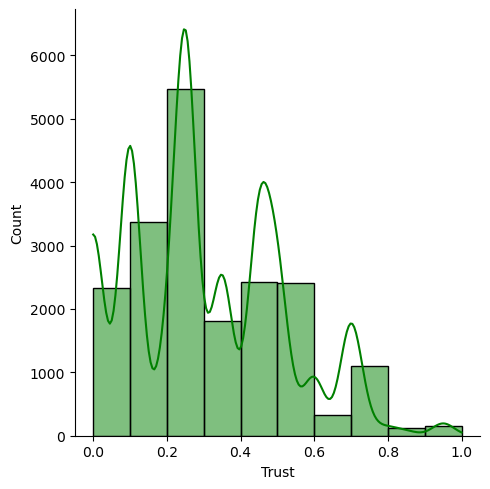

In [9]:
sns.displot(trust_sea, x="Trust", kde= True, color = 'green', bins = 10)

In [ ]:
# T(F) = Td(F).Wd + Ti(F).Wi + Ttime(F).Wtime
# Wd = 0.5
# Wi = 0.25
# Wtime = 0.25

# Td(F) = (Wnum.V_num) + (Wdir_c.Dir_C) + (Wuc.UC) + (Wedit.Tag_edits) + (WrollB.RollBk) + (WTag.Tag)
# Wnum = 0.2
# Wdir_c = 0.2
# Wuc = 0.2
# Wedit = 0.1
# WrollB = 0.1
# WTag = 0.2

In [ ]:
# To measure trustworthiness of sidewalk data: dir/indir indicators of the *road* that is associated with that sidewalk!

# Two steps:

# Check if sidewalk-data availabile or not. Four cases:
    # i) Partial availability (Case 1): sidewalk geometry available but tag is not available on the associated road
    # ii) Partial availability (Case 2): sidewalk geometry not availble, but sidewalk tag (yes/ left/ right/ both) is on the road
    # iii) Full availibility: Both sidewalk geometry and sidewalk tag on the associated road are available. Or, if sidewalk is not there then tag is (no/none)
    # iv) Unavailable: Neither geometry nor the tag of associated road is available

# if available, check if the associated road data is trustworthy or not

In [ ]:
# feature availability for sidewalk:left, sidewalk:right, sidewalk:both
# If sidewalk features are also and mostly available on associated roads, then we have to change approach. Discuss with professor!!

In [ ]:
# Indirect and time indicator measurable
# But direct indicator not so as sidewalk data only started to increase in recent times and barely have 2 tags only!! Still have to explore more for it

In [ ]:
# Instead of storing the pbf files for history or latest osm
# extract and store nodes, ways, relations (for latest osm data)
# and also other important attributes required (required for dir/indir indicators) for hisotrical data 
# create dataframes and store them in feather files!!

# And then extract them for direct or indirect indicators and use accordingly (Have to change a lot of code for that!!)

### For Highways with Sidewalk Tags

### Direct Indicators

In [4]:
dir_ind = extract_direct_indicators(highway_with_sidewalk_tag, 'sea')
dir_ind = dir_ind[dir_ind['visibility'] == 'V'] # Exclude deleted or changed entries
stats = get_stats_dir(dir_ind)
# Using ceil(mean) as central tendency measure
stats = stats.loc['mean'].apply(np.ceil).to_dict()

In [6]:
def compute_dir(**kwargs):
    res = dict()
    for key in kwargs:
        res[key]  = 1 if kwargs[key] >= stats[key] else 0

    Wnum, Wdir_c, Wuc, Wedit, WrollB, WTag = 0.2, 0.2, 0.2, 0.1, 0.1, 0.2
    Td = (Wnum * res['nversions']) + (Wdir_c * res['dir_confirmations']) + \
         (Wuc * res['nusers']) + (Wedit * res['nedits']) + \
         (WrollB * res['nrollbacks']) + (WTag * res['ntags'])

    return Td

dir_ind['Td'] = dir_ind.apply(lambda row: compute_dir(
                                                    nversions = row.nversions, 
                                                    dir_confirmations = row.dir_confirmations, 
                                                    nusers = row.nusers, 
                                                    nedits = row.nedits, 
                                                    nrollbacks = row.nrollbacks, 
                                                    ntags = row.ntags
                                                    ), 
                                                    axis=1)

In [28]:
dir_ind

id  nversions  nusers  nedits  ntags  dir_confirmations  \
1        4636259         31      19      21     16                 12   
2        4708342         19      13      14     11                  7   
3        4708348         36      12      13      9                  3   
5        4714349         20      10       9      6                  3   
6        4729721         17      11      25     14                  9   
...          ...        ...     ...     ...    ...                ...   
8931  1083636356          1       1       0     11                  0   
8932  1083636357          1       1       0     14                  0   
8933  1083636358          1       1       0     13                  0   
8934  1084284077          2       1       1     12                  0   
8935  1084284078          1       1       0     12                  0   

      nrollbacks visibility  \
1              1          V   
2              0          V   
3              0          V   
5              0          V   
6              0          V   
...          ...        ...   
8931           0          V   
8932           0          V   
8933           0          V   
8934           0          V   
8935           0          V   

                                                   tags type   Td  
1     {'bridge': 'yes', 'dual_carriageway': 'yes', '...    W  1.0  
2     {'bicycle': 'designated', 'cycleway:right': 's...    W  0.7  
3     {'bicycle': 'designated', 'cycleway': 'shared_...    W  0.5  
5     {'highway': 'tertiary', 'lanes': '2', 'maxspee...    W  0.5  
6     {'bicycle': 'designated', 'cycleway:left': 'tr...    W  0.9  
...                                                 ...  ...  ...  
8931  {'highway': 'residential', 'lanes': '2', 'maxs...    W  0.0  
8932  {'highway': 'residential', 'lanes': '2', 'lit'...    W  0.2  
8933  {'highway': 'residential', 'lanes': '2', 'lit'...    W  0.2  
8934  {'highway': 'residential', 'lanes': '1', 'maxs...    W  0.2  
8935  {'highway': 'residential', 'lanes': '1', 'maxs...    W  0.2  

[8706 rows x 11 columns]

### Time Indicator

In [23]:
time_ind = extract_time_indicator(highway_with_sidewalk_tag, 'sea')
stats = get_stats(time_ind)
avg = stats.loc['mean'].apply(np.ceil)[0] # Average last edit
time_ind['Ttime'] = time_ind.apply(lambda row: 1 if row['last_edit(months)'] >= avg else 0, axis=1)

In [35]:
time_ind

id                        ts  last_edit(months)  Ttime
0        4636259 2022-07-05 04:22:04+00:00                  1      0
1        4708342 2021-01-24 20:49:43+00:00                 19      1
2        4708348 2021-06-06 03:36:18+00:00                 14      1
3        4714349 2020-12-28 04:14:09+00:00                 20      1
4        4729721 2021-03-24 01:41:38+00:00                 17      1
...          ...                       ...                ...    ...
8605  1082648049 2022-07-31 09:31:58+00:00                  1      0
8606  1082648077 2022-07-31 09:31:58+00:00                  1      0
8607  1082648095 2022-07-31 09:31:58+00:00                  1      0
8608  1082932542 2022-08-01 12:01:33+00:00                  0      0
8609  1082932552 2022-08-01 12:01:33+00:00                  0      0

[8610 rows x 4 columns]

### Indirect Indicators

In [41]:
indir_ind = extract_indirect_indicators(highway_with_sidewalk_tag, 'sea')

stats = get_stats_indir(indir_ind)
# Using ceil(mean) as central tendency measure
stats = stats.loc['mean'].apply(np.ceil).to_dict()

invalid area (area_id=210393692)
osmium.osm.Area(id=210393692, deleted=False, visible=True, version=11, changeset=0, uid=0, timestamp=datetime.datetime(2021, 9, 1, 2, 58, 4, tzinfo=datetime.timezone.utc), user='', tags=osmium.osm.TagList({'landuse': 'residential', 'name': 'Olympic Manor'}))


In [42]:
def compute_indir(**kwargs):
    cnt = 0
    for key in kwargs:
        cnt  += 1 if kwargs[key] >= stats[key] else 0

    Ti = 1 if cnt >= 6 else 0

    return Ti

indir_ind['Ti'] = indir_ind.apply(lambda row: compute_indir(
                                                    road_cnt = row.road_cnt, 
                                                    road_uc = row.road_uc, 
                                                    road_le_time = row.road_le_time, 
                                                    building_cnt = row.building_cnt, 
                                                    building_uc = row.building_uc, 
                                                    building_le_time = row.building_le_time,
                                                    poi_cnt = row.poi_cnt,
                                                    poi_uc = row.poi_uc,
                                                    poi_le_time = row.poi_le_time,
                                                    target_cnt = row.target_cnt,
                                                    target_uc = row.target_uc,
                                                    target_le_time = row.target_le_time
                                                    ), 
                                                    axis=1)

In [43]:
indir_ind

id  road_cnt  road_uc  road_le_time  building_cnt  building_uc  \
0       6341522        30       30             2           135            7   
1       6343246        30       30             2           135            7   
2       6347900        30       30             2           135            7   
3       6408690        30       30             2           135            7   
4       6408695        30       30             2           135            7   
...         ...       ...      ...           ...           ...          ...   
8605  428077761        88       50             2           160            6   
8606  428077774        88       50             2           160            6   
8607  428077779        88       50             2           160            6   
8608    6515020        67       78             1           254            7   
8609  956426988        67       78             1           254            7   

      building_le_time  poi_cnt  poi_uc  poi_le_time  target_cnt  target_uc  \
0                    7       14       3           15          14         11   
1                    7       14       3           15          14         11   
2                    7       14       3           15          14         11   
3                    7       14       3           15          14         11   
4                    7       14       3           15          14         11   
...                ...      ...     ...          ...         ...        ...   
8605                 1        2       1            4           5          5   
8606                 1        2       1            4           5          5   
8607                 1        2       1            4           5          5   
8608                10        0       0            0           2          1   
8609                10        0       0            0           2          1   

      target_le_time  Ti  
0                  2   0  
1                  2   0  
2                  2   0  
3                  2   0  
4                  2   0  
...              ...  ..  
8605               2   0  
8606               2   0  
8607               2   0  
8608              14   0  
8609              14   0  

[8610 rows x 14 columns]

### Compute Trust

In [44]:
def compute_trust(Td, Ti, Ttime):
    trust = Td * 0.5 + Ti * 0.25 + Ttime * 0.25
    return trust

# Td(F).Wd + Ti(F).Wi + Ttime(F).Wtime
result = pd.merge(dir_ind, indir_ind, on="id")[['id', 'Td', 'Ti']]
result = pd.merge(result, time_ind, on="id")[['id', 'Td', 'Ti', 'Ttime']]
result['Trust'] = result.apply(lambda row: compute_trust(
                                                        row.Td,
                                                        row.Ti,
                                                        row.Ttime
                                                        ),
                                                        axis = 1)

In [ ]:
# Make changes to these to get the appropriate geometries
# h = WayHandler()
# h.apply_file("data/osm/latest/sea.osm.pbf", locations = True)
# sidewalk = h.get_gdf(sidewalk_qualifer)

# highway = h.get_gdf(highway_qualifier)

In [46]:
# Make changes to these to get the appropriate geometries
# result = pd.merge(result, sidewalk, on="id")[['id', 'Td', 'Ti', 'Trust', 'tags', 'geometry']]
# result = gpd.GeoDataFrame(result, crs="EPSG:4326")
result.to_csv('data/trust_indicator_highway_with_sidewalk_tag_seattle.csv', index=False)

In [ ]:
# fig, ax = plt.subplots(figsize=(50,150))

# highway.plot(color = 'red', lw = 1, ax=ax)
# result.plot(column = 'Trust', lw=1.5, ax=ax, cmap='viridis', legend = False)
# # plt.legend(title="My Title", fontsize=5)
# # plt.legend(prop = { 'size' : 30 })
# # plt.savefig('data/sea_sidewalk.png', dpi=400)

# fig = ax.get_figure()
# cax = fig.add_axes([1, 0.35, 0.02, 0.25]) # 3rd -> width
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0.1, vmax=1))
# sm._A = []
# cbr = fig.colorbar(sm, cax=cax,)
# # cbr.ax.tick_params(labelsize=200) 
# plt.tight_layout()
# plt.savefig('data/sea_sidewalk_trust.png', dpi=400)
# plt.show()

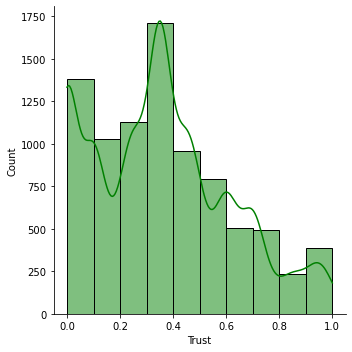

In [47]:
sns.displot(result, x="Trust", kde= True, color = 'green', bins = 10)

In [53]:
h = WayHandler()
h.apply_file("data/osm/latest/sea.osm.pbf", locations = True)
highway_with_sidewalk_tag = h.get_gdf(highway_with_sidewalk_tag)

### Count Sidewalk Sources

In [ ]:
h = WayHandler()
h.apply_file("data/osm/latest/sea.osm.pbf", locations = True)
sidewalks = h.get_gdf(sidewalk_qualifer)

In [80]:
from collections import defaultdict
cnt = defaultdict(lambda: 0)
def count_source(tag):
    global cnt
    if('source' in tag):
        cnt[tag.get('source')] += 1

sidewalks.apply(lambda row: count_source(
                                            row.tags
                                        ),
axis = 1)
cnt

defaultdict(<function __main__.<lambda>()>,
            {'survey, imagery': 32,
             'yahoo_wms': 390,
             'tiger': 1,
             'yahoo_wms;knowledge': 91,
             'USGS Large Scale Imagery': 87,
             'survey': 120,
             'tiger;Yahoo! aerial imagery': 8,
             'Bing': 315,
             'Yahoo,TIGER': 146,
             'TIGER 2005': 4,
             'bing': 128,
             'http://www.seattle.gov/dpd/AppDocs/GroupMeetings/DRProposal3015157AgendaID4778.pdf': 2,
             'TIGER;Yahoo! aerial imagery': 11,
             'King County': 1,
             'local_knowledge': 10,
             'yahoo_wms;TIGER': 4,
             'yahoo_wms, survey': 1,
             'Bing, King County': 5,
             'Yahoo;TIGER;USGS Large Scale Imagery': 6,
             'yahoo_wms;survey': 19,
             'King County GIS;data.seattle.gov': 1,
             'Local%20knowledge.%20This%20is%20a%20service%20road.%20Walnut%20Ave%20SW%20is%20to%20the%20east%20and%20